## Initialize

### Packages

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import ROOT as root
from scipy.optimize import curve_fit

### Constants

In [34]:
mass_proton = 0.938272
mass_neutron = 0.939565
mass_piminus = 0.139570
Deg_To_Rad = np.pi/180
transparency_pn = 0.904

## Fit the pn cross section $\sigma_{pn}$

### Determine the limits of proton momentum

In [35]:
Q2_low = 2
Q2_high = 8
p_proton_low = np.sqrt((Q2_low/2/mass_proton)**2 + Q2_low)
p_proton_high = np.sqrt((Q2_high/2/mass_proton)**2 + Q2_high)
print("Lowest proton momentum of fitting:", p_proton_low)
print("Highest proton momentum of fitting:", p_proton_high)

Lowest proton momentum of fitting: 1.7708490183138814
Highest proton momentum of fitting: 5.116102025039356


### Get the pn cross section table

In [36]:
sigma_pn_table = np.loadtxt("input/rpp2022-pn_total.dat", skiprows=11, dtype=str)
sigma_pn_table = sigma_pn_table[:, 0:9].astype(float)
sigma_pn_table = sigma_pn_table[15:44]

### Fit to a constant value

Text(0, 0.5, '$\\sigma _{pn} [mb]$')

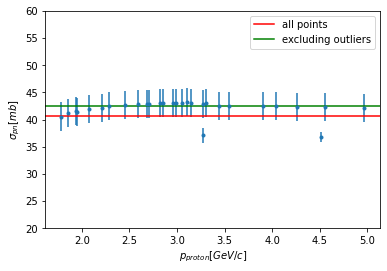

In [37]:
def constant(x, c):
    return c

plt.errorbar(sigma_pn_table[:,1], sigma_pn_table[:,4], yerr=sigma_pn_table[:,5]+sigma_pn_table[:,7], xerr = sigma_pn_table[:,1]-sigma_pn_table[:,2], fmt=".")

popt, pcov = curve_fit(constant, sigma_pn_table[:,1], sigma_pn_table[:,4], sigma=sigma_pn_table[:,5]+sigma_pn_table[:,7]) 
plt.axhline(popt, 0, 1, color="r", label="all points")

sigma_pn = popt

sigma_pn_table = np.delete(sigma_pn_table, 18, axis=0)
sigma_pn_table = np.delete(sigma_pn_table, 25, axis=0)

popt, pcov = curve_fit(constant, sigma_pn_table[:,1], sigma_pn_table[:,4], sigma=sigma_pn_table[:,5]+sigma_pn_table[:,7]) 
plt.axhline(popt, 0, 1, color="g", label="excluding outliers")

plt.legend()
plt.ylim(20,60)
plt.xlabel(r"$p_{proton} [GeV/c]$")
plt.ylabel(r"$\sigma _{pn} [mb]$")

## Get the $d(\gamma, \pi^{-} p)$ transparency

### Get the $\pi^{-}p$ and $ pp $ cross section table

In [38]:
sigma_pimp_table = np.loadtxt("input/rpp2022-pimp_total.dat", skiprows=11, dtype=str)
sigma_pimp_table = sigma_pimp_table[:, 0:9].astype(float)
sigma_pimp_table = sigma_pimp_table[0:506]

sigma_pp_table = np.loadtxt("input/rpp2022-pp_total.dat", skiprows=11, dtype=str)
sigma_pp_table = sigma_pp_table[:, 0:9].astype(float)
sigma_pp_table = sigma_pp_table[0:159]

### Function to calculate the total transparency

In [39]:
def total_transparency_semiclassical(energy, theta):

    P4_gamma = root.TLorentzVector(0, 0, energy, energy)
    P4_neutron = root.TLorentzVector(0, 0, 0, mass_neutron)

    s = (P4_gamma + P4_neutron).Mag2()
    pf_cm = np.sqrt(((s-mass_piminus**2-mass_proton**2)**2-4*mass_piminus**2*mass_proton**2)/(4*s))

    P4_piminus = root.TLorentzVector()
    P4_proton = root.TLorentzVector()
    P4_piminus.SetXYZM(0, pf_cm*np.sin(theta*Deg_To_Rad), pf_cm*np.cos(theta*Deg_To_Rad), mass_piminus)
    P4_proton.SetXYZM(0, -pf_cm*np.sin(theta*Deg_To_Rad), -pf_cm*np.cos(theta*Deg_To_Rad), mass_proton)

    boost_cm = (P4_gamma+P4_neutron).BoostVector()

    P4_piminus.Boost(boost_cm)
    P4_proton.Boost(boost_cm)
    
    if (P4_piminus.P() < sigma_pimp_table[0][2]) or (P4_piminus.P() > sigma_pimp_table[-1][2]) or (P4_proton.P() < sigma_pp_table[0][2]) or (P4_proton.P() > sigma_pp_table[-1][2]):
        return -1
    else:
        sigma_pimp = sigma_pimp_table[np.argmax(sigma_pimp_table[:,2]>P4_piminus.P()), 4]
        sigma_pp = sigma_pp_table[np.argmax(sigma_pp_table[:,2]>P4_proton.P()), 4]

        transparency_pimp = np.exp(sigma_pimp/sigma_pn*np.log(transparency_pn))
        transparency_pp = np.exp(sigma_pp/sigma_pn*np.log(transparency_pn))

        return transparency_pimp*transparency_pp

### Calculate the total transparency given the points

In [18]:
bins_energy = np.loadtxt("input/bins_energy_piminus_p_2H.txt")
bins_theta = np.loadtxt("input/bins_theta_piminus_p_2H.txt")

transparency_table = np.zeros((len(bins_energy), len(bins_theta)))
for i in range(len(bins_energy)):
    for j in range(len(bins_theta)):
        transparency_table[i][j] = total_transparency(bins_energy[i,0], bins_theta[j,0])

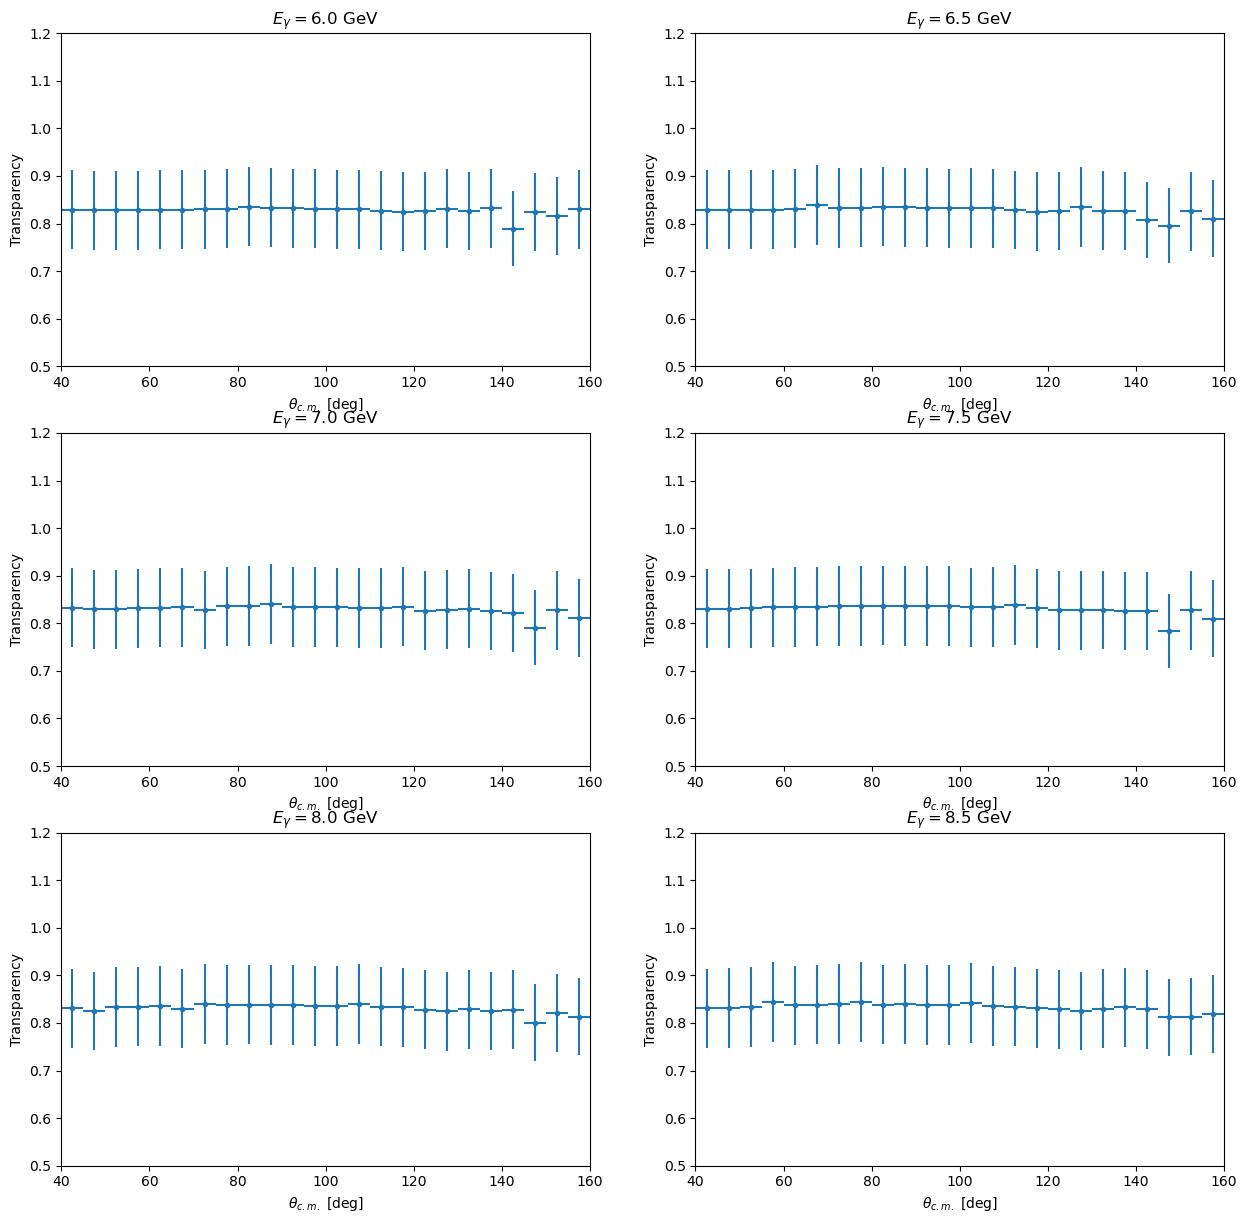

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15), dpi=100)

for i, ax in enumerate(axs.flat):
    plt.axes(ax)
    plt.ylim(0.5, 1.2)
    plt.xlim(40, 160)
    plt.ylabel("Transparency")
    plt.xlabel(r"$\theta_{c.m.}$ [deg]")
    plt.title(r"$E_{\gamma}=$"+str(0.5*i+6)+" GeV")
    plt.errorbar(bins_theta[:,0], transparency_table[i, :], yerr = transparency_table[i, :]*0.1, xerr = 2.5, fmt=".")

### Save the results to text file

In [14]:
np.savetxt("output/transparency_piminus_p_2H.txt", transparency_table, fmt='%9.5f')

In [40]:
c_list = np.array([0.90457337e0, -0.35058661e0, -0.17635927e0, -0.10418261e2, 0.45089439e2, -0.14861947e3, 0.31779642e3, -0.37496518e3, 0.22560032e3, -0.54858290e2])
c_list = np.append(c_list, -c_list.sum())
m_list = np.zeros((11))
for i in range(11):
    m_list[i] = 0.231609 + 0.9*i
    
u_0 = np.sum(c_list/m_list**2)
J = -1/(2*np.pi)*np.sum(c_list*np.log(m_list))

In [32]:
def total_transparency_diagrammatic(energy, theta):

    P4_gamma = root.TLorentzVector(0, 0, energy, energy)
    P4_neutron = root.TLorentzVector(0, 0, 0, mass_neutron)

    s = (P4_gamma + P4_neutron).Mag2()
    pf_cm = np.sqrt(((s-mass_piminus**2-mass_proton**2)**2-4*mass_piminus**2*mass_proton**2)/(4*s))

    P4_piminus = root.TLorentzVector()
    P4_proton = root.TLorentzVector()
    P4_piminus.SetXYZM(0, pf_cm*np.sin(theta*Deg_To_Rad), pf_cm*np.cos(theta*Deg_To_Rad), mass_piminus)
    P4_proton.SetXYZM(0, -pf_cm*np.sin(theta*Deg_To_Rad), -pf_cm*np.cos(theta*Deg_To_Rad), mass_proton)

    boost_cm = (P4_gamma+P4_neutron).BoostVector()

    P4_piminus.Boost(boost_cm)
    P4_proton.Boost(boost_cm)
    
    if (P4_piminus.P() < sigma_pimp_table[0][2]) or (P4_piminus.P() > sigma_pimp_table[-1][2]) or (P4_proton.P() < sigma_pp_table[0][2]) or (P4_proton.P() > sigma_pp_table[-1][2]):
        return -1
    else:
        sigma_pimp = sigma_pimp_table[np.argmax(sigma_pimp_table[:,2]>P4_piminus.P()), 4]
        sigma_pp = sigma_pp_table[np.argmax(sigma_pp_table[:,2]>P4_proton.P()), 4]

        return ((u_0-0.25*J*(sigma_pimp+sigma_pp)/10)/u_0)**2

In [63]:
bins_energy = np.arange(1.0, 11.0, 0.5)
bins_theta = np.arange(40, 160, 1)

transparency_table_diagrammatic = np.zeros((len(bins_energy), len(bins_theta)))
transparency_table_semiclassical = np.zeros((len(bins_energy), len(bins_theta)))
for i in range(len(bins_energy)):
    for j in range(len(bins_theta)):
        transparency_table_diagrammatic[i][j] = total_transparency_diagrammatic(bins_energy[i], bins_theta[j])
        transparency_table_semiclassical[i][j] = total_transparency_semiclassical(bins_energy[i], bins_theta[j])

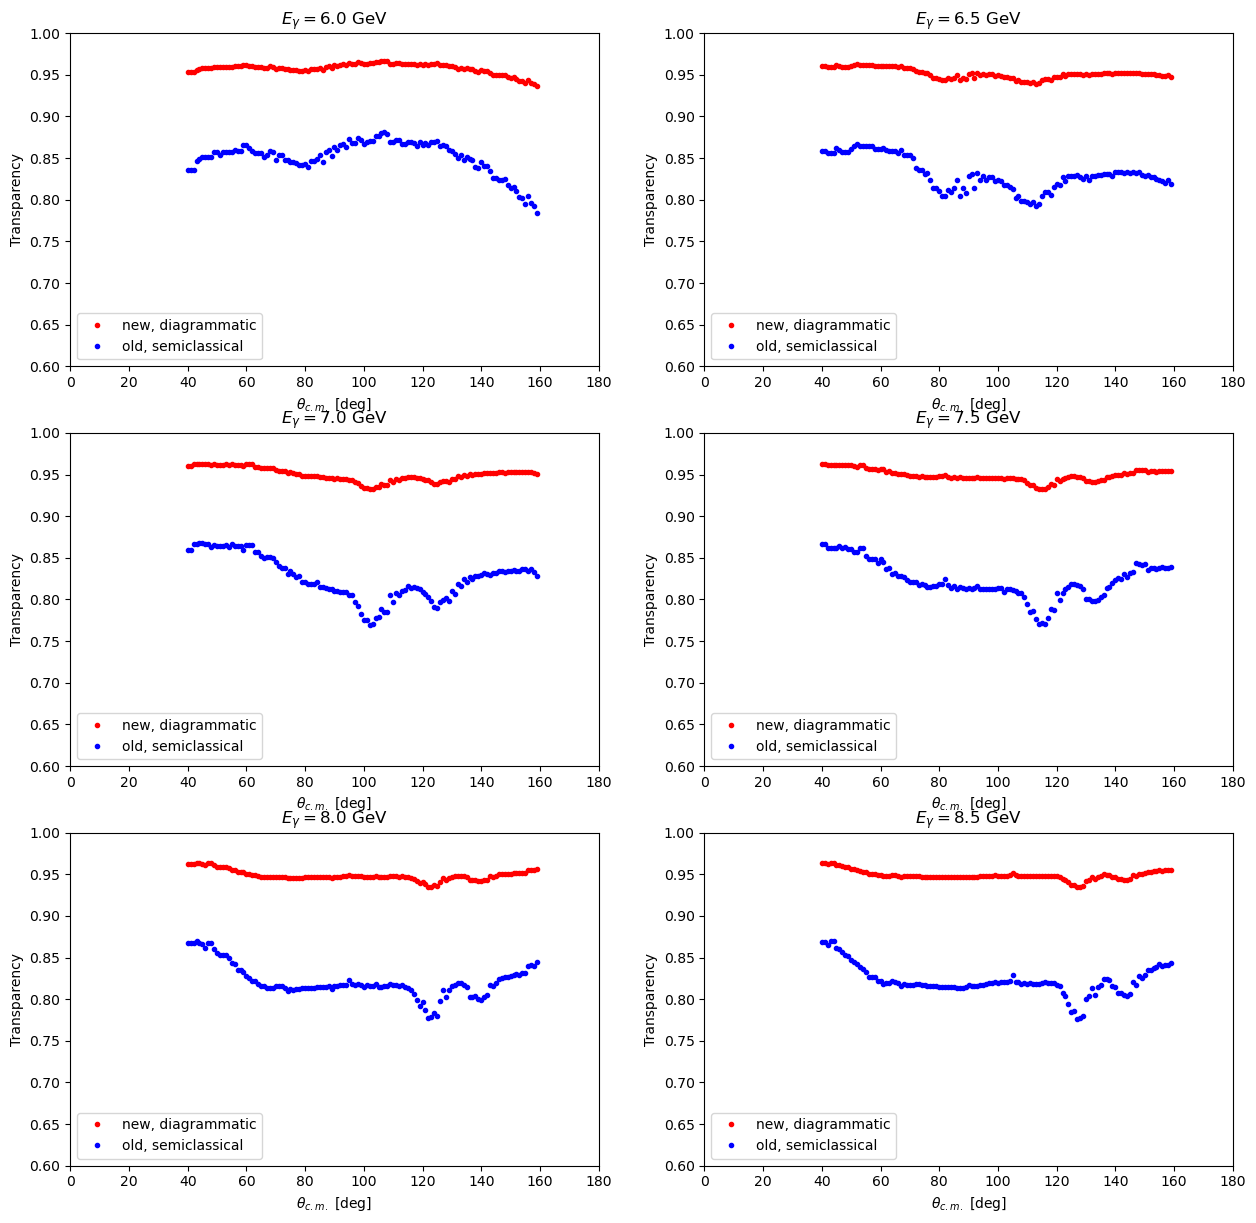

In [64]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15), dpi=100)

for i, ax in enumerate(axs.flat):
    plt.axes(ax)
    plt.ylim(0.6, 1.0)
    plt.xlim(0, 180)
    plt.ylabel("Transparency")
    plt.xlabel(r"$\theta_{c.m.}$ [deg]")
    plt.title(r"$E_{\gamma}=$"+str(0.5*i+6)+" GeV")
    plt.errorbar(bins_theta[:], transparency_table_diagrammatic[i, :], fmt=".", color='r', label='new, diagrammatic')
    plt.errorbar(bins_theta[:], transparency_table_semiclassical[i, :], fmt=".", color='b', label='old, semiclassical')
    plt.legend()